# Tutorial: Minimum Eigen Optimizer

For original tutorial refer to https://qiskit.org/documentation/optimization/tutorials/03_minimum_eigen_optimizer.html

In [1]:
! pip install qiskit_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.5/633.5 kB 4.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.25.236-py3-none-any.whl size=671350 sha256=9249c6a84de2faf8bdcbab214a249d5d0f59baacde525363554a1e68347f1283
  Stored in directory: /home/robotastray/.cache/pip/wheels/b8/98/f8/22c3fe8d29be988cc4584363f494a459fb8f09c16d8e438ac7
Successfully built docplex


In [2]:
from typing import List, Tuple

import numpy as np

from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram

from qiskit_braket_provider import AWSBraketProvider

### Converting a QUBO to an Operator

In [3]:
# create a QUBO
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(
    linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2}
)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x - 2 y + 3 z + [ 2 x*y - 2 x*z + 4 y*z ]/2
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



In [4]:
op, offset = qubo.to_ising()
print(f"offset: {offset}")
print("operator:")
print(op)

offset: 1.5
operator:
-0.5 * IIZ
+ 0.25 * IZI
- 1.75 * ZII
+ 0.25 * IZZ
- 0.25 * ZIZ
+ 0.5 * ZZI


In [5]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x0 - 2 x1 + 3 x2 + [ 2 x0*x1 - 2 x0*x2 + 4 x1*x2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End



### Solving a QUBO with the MinimumEigenOptimizer


In [6]:
algorithm_globals.random_seed = 10598

quantum_instance = QuantumInstance(
    AWSBraketProvider().backends(local=True)[0],
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

/tmp/ipykernel_69023/2374560280.py:3: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(
/tmp/ipykernel_69023/2374560280.py:8: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 0.0])
/tmp/ipykernel_69023/2374560280.py:9: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no ea

In [7]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(
    exact_mes
)  # using the exact classical numpy minimum eigen solver

In [8]:
exact_result = exact.solve(qubo)
print(exact_result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


In [10]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


### Analysis of Samples

In [11]:
print("variable order:", [var.name for var in qaoa_result.variables])
for smpl in qaoa_result.samples:
    print(smpl)

variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.123046875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.302734375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.0888671875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.22851562500000003, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.12500000000000003, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.025390624999999997, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.10644531250000001, status=<OptimizationResultStatus.SUCCESS: 0>)


In [12]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (
        OptimizationResultStatus.SUCCESS,
    ),
):
    """Returns filtered samples."""
    res = []
    for sample in samples:
        if sample.status in allowed_status and sample.probability > threshold:
            res.append(sample)

    return res

In [13]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples,
    threshold=0.005,
    allowed_status=(OptimizationResultStatus.SUCCESS,),
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.123046875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.302734375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.0888671875, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.22851562500000003, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.12500000000000003, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.025390624999999997, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.10644531250000001, status=<OptimizationResultStatus.SUCCESS: 0>)


In [14]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [15]:
np.mean(fvals)

1.7142857142857142

In [16]:
np.std(fvals)

1.979486637221574

In [17]:
samples_for_plot = {
    " ".join(
        f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(smpl.x)
    ): smpl.probability
    for smpl in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 0.123046875,
 'x=1 y=1 z=0': 0.302734375,
 'x=1 y=0 z=0': 0.0888671875,
 'x=0 y=0 z=1': 0.22851562500000003,
 'x=1 y=0 z=1': 0.12500000000000003,
 'x=0 y=1 z=1': 0.025390624999999997,
 'x=1 y=1 z=1': 0.10644531250000001}

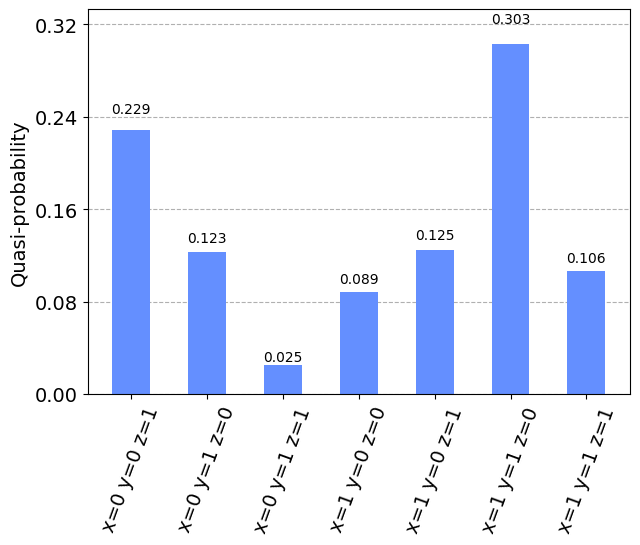

In [18]:
plot_histogram(samples_for_plot)

### RecursiveMinimumEigenOptimizer

In [19]:
rqaoa = RecursiveMinimumEigenOptimizer(
    qaoa, min_num_vars=1, min_num_vars_optimizer=exact
)

In [20]:
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result)

fval=-2.0, x=0.0, y=1.0, z=0.0, status=SUCCESS


In [21]:
filtered_samples = get_filtered_samples(
    rqaoa_result.samples,
    threshold=0.005,
    allowed_status=(OptimizationResultStatus.SUCCESS,),
)

In [22]:
samples_for_plot = {
    " ".join(
        f"{rqaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)
    ): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 1.0}

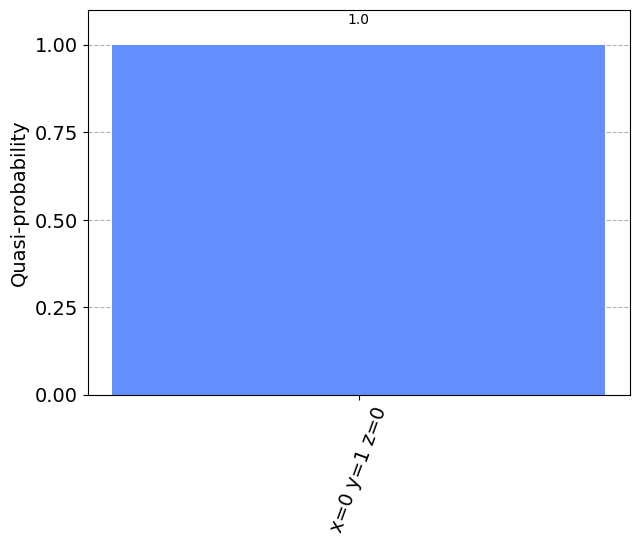

In [23]:
plot_histogram(samples_for_plot)